In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [159]:
df = pd.read_csv('BostonHousing.csv')

In [160]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [161]:
df.dropna(inplace=True)

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     501 non-null    float64
 1   zn       501 non-null    float64
 2   indus    501 non-null    float64
 3   chas     501 non-null    int64  
 4   nox      501 non-null    float64
 5   rm       501 non-null    float64
 6   age      501 non-null    float64
 7   dis      501 non-null    float64
 8   rad      501 non-null    int64  
 9   tax      501 non-null    int64  
 10  ptratio  501 non-null    float64
 11  b        501 non-null    float64
 12  lstat    501 non-null    float64
 13  medv     501 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 58.7 KB


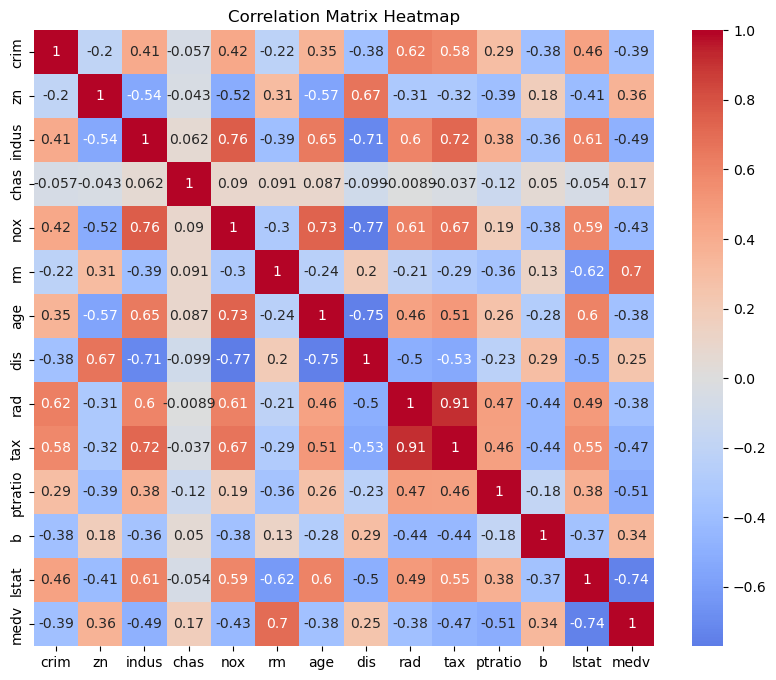

In [163]:
# Create correlation matrix heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [164]:
X = df.drop(columns=['medv'])
y = df['medv']

In [165]:
# Since the dataset has high-colinearity we will use Ridge regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [166]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=41,)

In [167]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test) 

In [168]:
reg = Ridge(alpha=1)

In [169]:
reg.fit(X_train_scaled,y_train)

Ridge(alpha=1)

In [170]:
y_pred = reg.predict(X_test_scaled)
r2_score(y_test,y_pred)

0.6715423545948211

In [171]:
class ActualRidge:
    # Mathematical Intution
    def __init__(self,alpha=1):
        
        self.alpha = alpha
        self.coef_ = None
        self.intercept_ = None
        
    def fit(self,X_train,y_train):
        
        X_train = np.insert(X_train,0,1,axis=1) 
        I = np.identity(X_train.shape[1])
        I[0][0] = 0
        result = np.linalg.inv(np.dot(X_train.T,X_train) + self.alpha * I).dot(X_train.T).dot(y_train)
        self.intercept_ = result[0]
        self.coef_ = result[1:]
    
    def predict(self,X_test):
        return np.dot(X_test,self.coef_) + self.intercept_

In [172]:
reg = ActualRidge()
reg.fit(X_train_scaled,y_train)
y_pred = reg.predict(X_test_scaled)
print(r2_score(y_test,y_pred))

0.6715423545948214


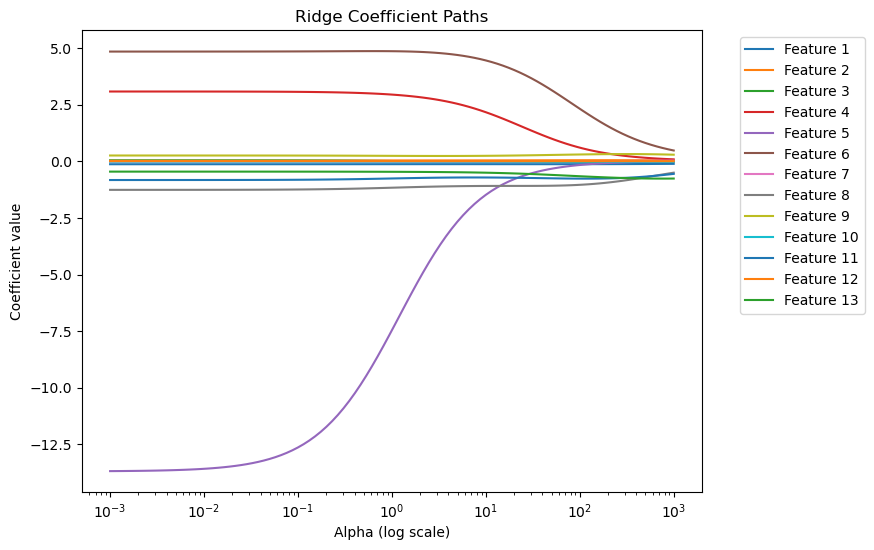

In [173]:
alphas = np.logspace(-3, 3, 100)  # 0.001 to 1000
coefs = []

for a in alphas:
    model = ActualRidge(alpha=a)
    model.fit(X_train, y_train)
    coefs.append(model.coef_)

coefs = np.array(coefs)

plt.figure(figsize=(8,6))
for i in range(coefs.shape[1]):
    plt.plot(alphas, coefs[:, i], label=f'Feature {i+1}')

plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficient value')
plt.title('Ridge Coefficient Paths')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


#Left side (small α) → model variance is high, coefficients can be unstable.
#Right side (large α) → model is stable, but may underfit.
#Middle α (~1-10) → stable coefficients with reasonable magnitudes → good candidate for Ridge α.


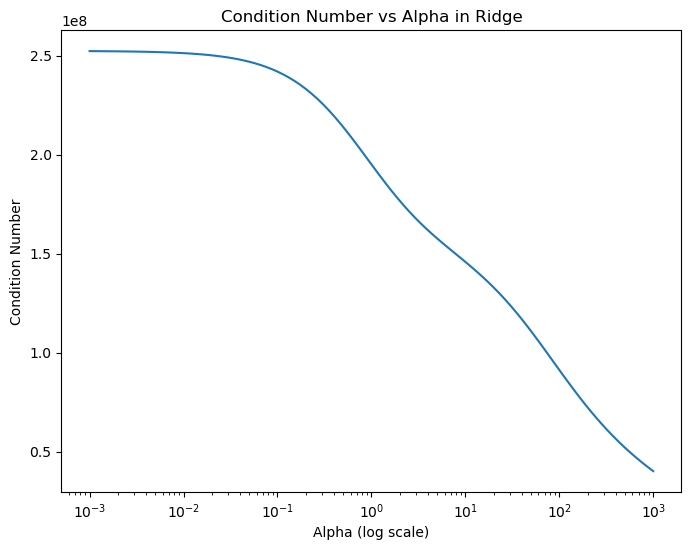

In [174]:
condition_numbers = []

for a in alphas:
    X_train_aug = np.insert(X_train, 0, 1, axis=1)
    I = np.identity(X_train_aug.shape[1])
    I[0][0] = 0
    mat = X_train_aug.T @ X_train_aug + a * I
    cond_num = np.linalg.cond(mat)
    condition_numbers.append(cond_num)

plt.figure(figsize=(8,6))
plt.plot(alphas, condition_numbers)
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Condition Number')
plt.title('Condition Number vs Alpha in Ridge')
plt.show()

In [178]:
class ActualLasso:
    def __init__(self, alpha=1.0, max_iter=1000, tol=1e-4):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X_train, y_train):
        n_samples, n_features = X_train.shape
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0

        for _ in range(self.max_iter):
            old_coef = self.coef_.copy()

            for j in range(n_features):
                y_pred = np.dot(X_train, self.coef_) + self.intercept_
                residual = y_train - (y_pred - X_train[:, j] * self.coef_[j])

                rho = np.dot(X_train[:, j], residual)

                if rho > self.alpha / 2:
                    self.coef_[j] = (rho - self.alpha / 2) / (np.dot(X_train[:, j], X_train[:, j]))
                elif rho < -self.alpha / 2:
                    self.coef_[j] = (rho + self.alpha / 2) / (np.dot(X_train[:, j], X_train[:, j]))
                else:
                    self.coef_[j] = 0

            if np.sum(np.abs(self.coef_ - old_coef)) < self.tol:
                break

        self.intercept_ = np.mean(y_train - np.dot(X_train, self.coef_))

    def predict(self, X_test):
        return np.dot(X_test, self.coef_) + self.intercept_


In [180]:
lasso_model = ActualLasso(alpha=10, max_iter=2000)
lasso_model.fit(X_train_scaled, y_train)
y_pred = lasso_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)

print("ActualLasso Coefficients:", np.round(lasso_model.coef_, 2))
print("ActualLasso Intercept:", np.round(lasso_model.intercept_, 2))
print("R2 Score:", r2)

ActualLasso Coefficients: [-1.12  0.81  0.14  0.8  -1.48  3.15 -0.29 -2.48  2.01 -1.83 -1.7   0.89
 -3.16]
ActualLasso Intercept: 22.45
R2 Score: 0.6709783849862414


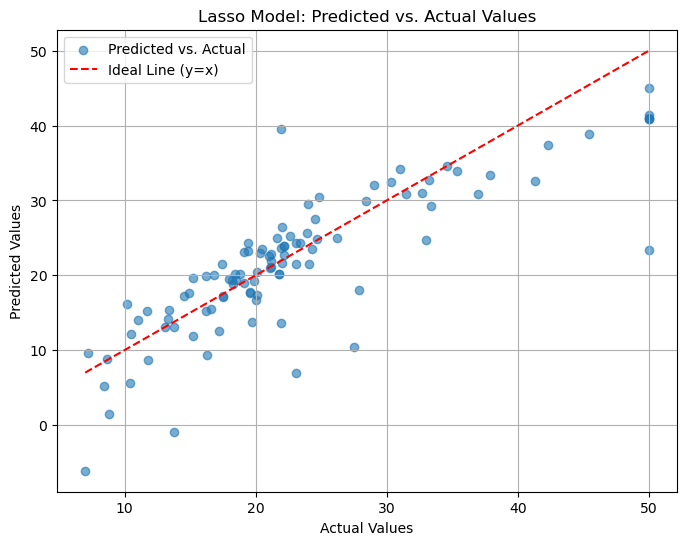

In [ ]:
# Create a scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs. Actual')

# Plot the ideal regression line where predicted = actual
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='Ideal Line (y=x)')

plt.title('Lasso Model: Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()